In [1]:
from glob import glob
import numpy as num
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/Cat"

In [4]:
hr=[]
lr=[]

In [ ]:
#our SR -GAN would be taking low resolution images as input into its generator
#to generate a low resolution image we can use filters or we can just simply resize to lower size(32*32)
#our dataset contains cat images of different shapes so we need to reize them in a praticual shape (128*128)

LOAD HIGH AND LOW RESOLUTION IMAGES

In [5]:
for img in os.listdir(path):
  pth=os.path.join(path,img)
  image=cv2.imread(pth,1)
  try:
    img_lr=cv2.resize(image,(32,32))
    img_hr=cv2.resize(image,(128,128))
  except Exception as e:
    pass
  hr.append(img_hr)
  lr.append(img_lr)
 # plt.figure(figsize=(8,8))
  #plt.subplot(1,2,1)
  #plt.imshow(img_lr)
  #plt.subplot(1,2,2)
  #plt.imshow(img_hr)
  #break

In [6]:
hr=num.array(hr)
lr=num.array(lr)

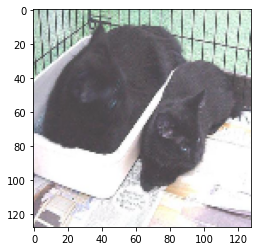

In [7]:
plt.imshow(hr[0]/255.0)

In [8]:
print(hr.shape)
print(lr.shape)

(1310, 128, 128, 3)
(1310, 32, 32, 3)


## Generator Architecture

In [9]:
def res_block(inp):
    l1=Conv2D(64,(3,3),padding="same",strides=1)(inp)
    l1=BatchNormalization(momentum=0.5)(l1)
    l1=PReLU(shared_axes=[1,2])(l1)

    l1=Conv2D(64,(3,3),padding="same")(l1)
    l1=BatchNormalization(momentum=0.5)(l1)

    return add([inp,l1])


In [10]:
def up_scaling(inp):
  l1=Conv2D(256,(3,3),padding="same")(inp)
  l1=UpSampling2D(size=2)(l1)
  l1=PReLU(shared_axes=[1,2])(l1)

  return l1

In [11]:
def generator(h,l,c):
  inp=Input(shape=(h,l,c))

  k1=Conv2D(64,(9,9),padding="same")(inp)
  k1=PReLU(shared_axes=[1,2])(k1)
  temp=k1
  res_blck_no=16

  for i in range(16):
    k1=res_block(k1)

  c2=Conv2D(64,(3,3),padding="same")(k1)  
  c2=BatchNormalization(momentum=0.5)(c2)
  c2=add([c2,temp])
  
  c2=up_scaling(c2)
  c2=up_scaling(c2)

  op=Conv2D(3,(9,9),padding="same")(c2)

  return Model(inputs=inp,outputs=op)


In [12]:
gen=generator(32,32,3)

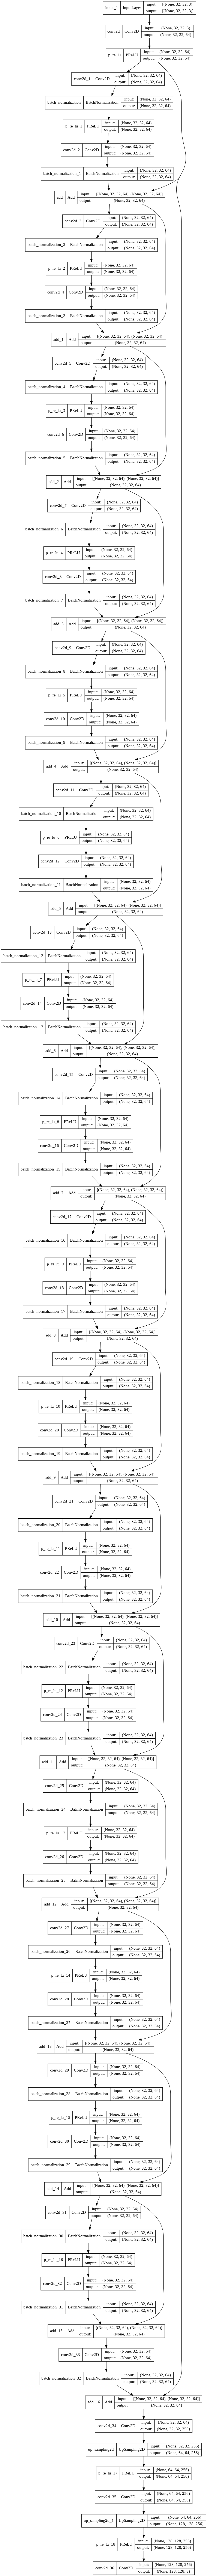

In [13]:
tf.keras.utils.plot_model(gen,show_shapes=True)

### Discriminator Architecture

In [14]:
def disc_layer(inp,n,s):
  s1=Conv2D(n,(3,3),strides=s,padding="same")(inp)
  s1=BatchNormalization(momentum=0.8)(s1)
  s1=LeakyReLU(alpha=0.2)(s1)

  return s1

In [15]:
def discriminator(h,w,c):
  inp=Input(shape=(h,w,c))
  d1=Conv2D(64,(3,3),padding="same",strides=1)(inp)
  d1=LeakyReLU(alpha=0.2)(d1)

  d1=disc_layer(d1,64,2)
  d1=disc_layer(d1,128,1)
  d1=disc_layer(d1,128,2)
  d1=disc_layer(d1,256,1)
  d1=disc_layer(d1,256,2)
  d1=disc_layer(d1,512,1)
  d1=disc_layer(d1,512,2)

  d2=Flatten()(d1)
  d2=Dense(64*16)(d2)
  d2=LeakyReLU(alpha=0.2)(d2)
  d2=Dense(1,activation="sigmoid")(d2)

  return Model(inp,d2)

In [16]:
dis=discriminator(128,128,3)

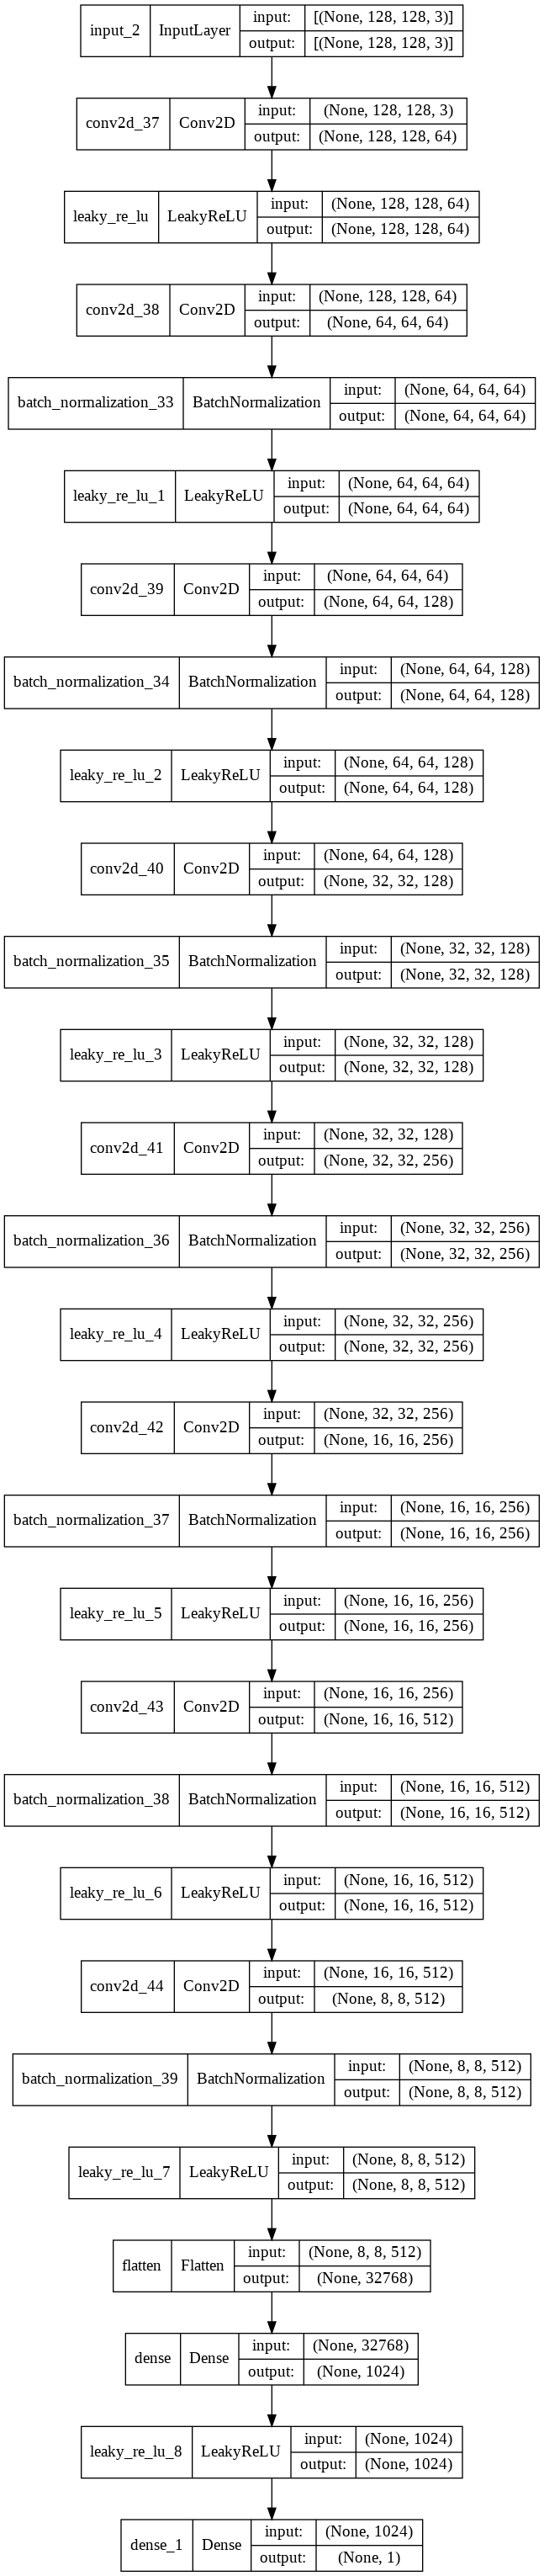

In [17]:
tf.keras.utils.plot_model(dis,show_shapes=True)

### GAN ARCHITECTURE COMBINED

In [18]:
def combine_gan(gen,dis,hr,lr,vgg):
  gen_out=gen(lr)

  feat=vgg(gen_out)
  #keep the discriminator non-trainable for now
  dis.trainable=False

  val=dis(gen_out)

  return Model(inputs=[lr,hr],outputs=[val,feat])


In [19]:
import tensorflow as tf




In [20]:
def vgg_model(h,w,c):
  vgg=tf.keras.applications.vgg19.VGG19(weights="imagenet",include_top=False, input_shape=(h,w,c))
  return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [21]:
inp_1=Input(shape=(32,32,3))
inp_2=Input(shape=(128,128,3))
vgg=vgg_model(128,128,3)
vgg.trainable=False

80150528/80134624 [==============================] - 0s 0us/step


In [22]:
comb=combine_gan(gen,dis,inp_2,inp_1,vgg)

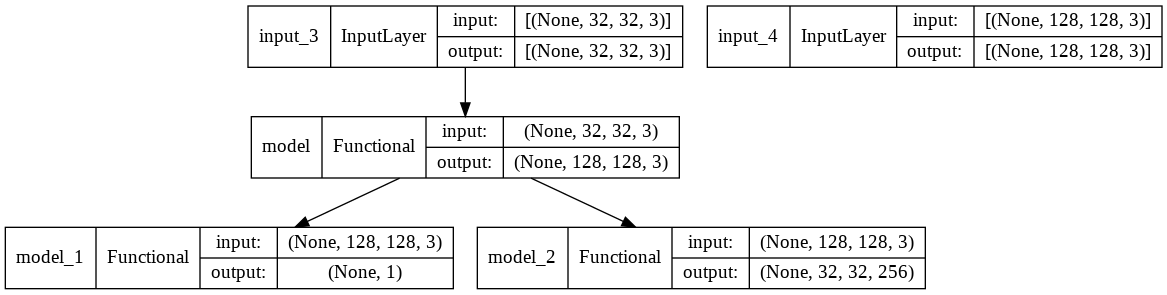

In [23]:
tf.keras.utils.plot_model(comb,show_shapes=True)

In [24]:
def train(gen,dis,comb,batch_size,epochs,hr,lr,vgg):

  half_batch=int(batch_size/2)

  batch_step=int(hr.shape[0]/batch_size)

  for epoch in range(epochs):
    s=0
    d_losses=[]
    g_losses=[]
    for batch in range(batch_step):
      fak_gen=gen.predict(lr[s:s+half_batch])

      dis.trainable=True
      
      dis_fake_loss=dis.train_on_batch(fak_gen,num.zeros((half_batch,1)))
      dis_real_loss=dis.train_on_batch(hr[s:s+half_batch],num.ones((half_batch,1)))

      dis.trainable=False
      d_loss=0.5*num.add(dis_real_loss,dis_fake_loss)

      feature=vgg.predict(hr[s:s+batch_size])
      out=num.ones((batch_size,1))

      g_loss,_,_=comb.train_on_batch([lr[s:s+batch_size],hr[s:s+batch_size]],[out,feature])

      s=s+batch_size
      d_losses.append(d_loss)
      g_losses.append(g_loss)


    d_losses=num.array(d_losses)

    g_losses=num.array(g_losses)  

    d_l=num.sum(d_losses,axis=0)/len(d_losses)
    g_l=num.sum(g_losses,axis=0)/len(g_losses)


    print("epoch:", epoch+1 ,"g_loss:", g_l, "d_loss:", d_l)



In [25]:
hr=hr/255.0
lr=lr/255.0


In [26]:
dis.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

comb.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")

In [36]:
train(gen,dis,comb,2,20,hr,lr,vgg)

epoch: 1 g_loss: 33.224860617950675 d_loss: [0.69313234 0.51145038]
epoch: 2 g_loss: 33.09090084338006 d_loss: [0.69313825 0.51068702]
epoch: 3 g_loss: 32.87898161211086 d_loss: [0.6931445  0.51068702]
epoch: 4 g_loss: 32.92286183597477 d_loss: [0.69314253 0.51221374]
epoch: 5 g_loss: 32.58265726511715 d_loss: [0.69315113 0.51221374]
epoch: 6 g_loss: 32.528826007406224 d_loss: [0.69314902 0.51221374]
epoch: 7 g_loss: 93.92979615189647 d_loss: [0.69325672 0.50916031]
epoch: 8 g_loss: 34.083101259479086 d_loss: [0.69311291 0.51526718]
epoch: 9 g_loss: 33.036374230421224 d_loss: [0.69312387 0.51068702]
epoch: 10 g_loss: 32.785349492080336 d_loss: [0.69314504 0.50763359]
epoch: 11 g_loss: 32.625789543326576 d_loss: [0.69314792 0.50687023]
epoch: 12 g_loss: 32.329062547756514 d_loss: [0.69315562 0.50534351]
epoch: 13 g_loss: 32.25076949432606 d_loss: [0.69316204 0.50534351]
epoch: 14 g_loss: 32.17546472913436 d_loss: [0.69316084 0.50687023]
epoch: 15 g_loss: 31.99745701942735 d_loss: [0.693

In [58]:
#I HAVE ALL READY RAN THIS MODEL FOR 50 EPOCHS BEFORE AND RE RAN IT SO ITS ABOUT 70 EPOCHS!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


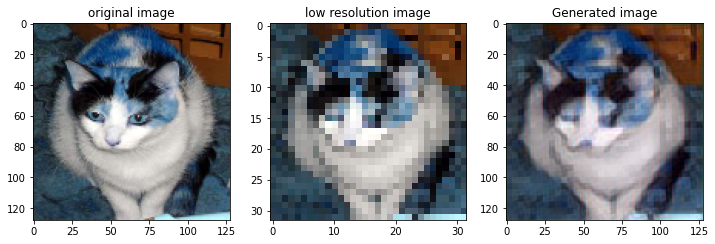

In [57]:
p=num.random.randint(0,1000)
samp=lr[p]
samp=num.expand_dims(samp,axis=0)
pred=gen.predict(samp)
pred=num.squeeze(pred)
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.title("original image")
plt.imshow(hr[p])
plt.subplot(1,3,2)
plt.title("low resolution image")
plt.imshow(lr[p])


plt.subplot(1,3,3)
plt.title("Generated image")
plt.imshow(pred)


